# Perform Gitclone & Install Missing Libraries

Every rerun, you need to reset the environment. Then import the CRANN github repo

In [ ]:
%reset -f
!git clone https://github.com/rdemedrano/crann_traffic.git

Cloning into 'crann_traffic'...
remote: Enumerating objects: 224, done.
remote: Counting objects: 100% (224/224), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 224 (delta 60), reused 198 (delta 45), pack-reused 0
Receiving objects: 100% (224/224), 30.09 MiB | 24.07 MiB/s, done.
Resolving deltas: 100% (60/60), done.


In [ ]:
%cd crann_traffic/

/content/crann_traffic


If any library is missing while running the model, here is the installer:

In [ ]:
!pip install configargparse

According to the papers' workflow, before we can train the dense submodel, we need to begin with the temporal and the spatial modules - train them first.

# Temporal Module

In [ ]:
%cd Temporal\ module

/content/crann_traffic/Temporal module


Import libraries

In [ ]:
import os
import json
import numpy as np

import torch

from dataset import data_transform
from utils import DotDict, Logger, denormalize_data, rmse, bias, rel_error
from bahdanau_att import EncoderLSTM, BahdanauDecoder


import matplotlib.pyplot as plt
%matplotlib inline

Import the dataset

Text(0, 0.5, 'Traffic intensity')

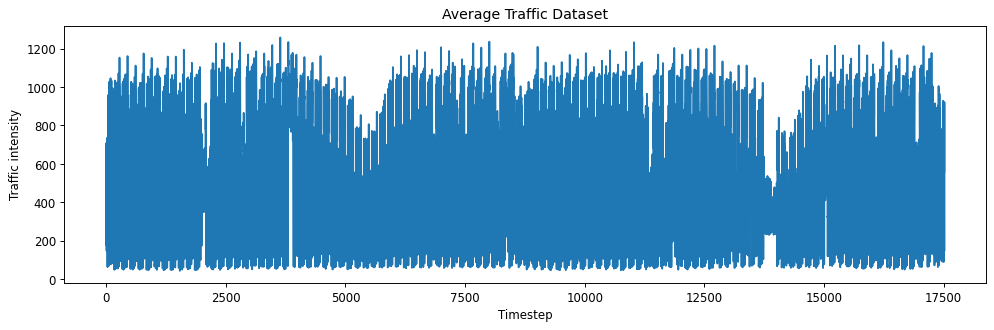

In [ ]:
datadir = 'data'
dataset = 'tem_data.csv'
data = torch.Tensor(np.genfromtxt(os.path.join('..',datadir, dataset)))

plt.figure('Average Traffic Dataset', figsize=(14, 4), dpi=85)
plt.plot(data.squeeze().numpy())
plt.title('Average Traffic Dataset')
plt.xlabel('Timestep')
plt.ylabel('Traffic intensity')

Run the training file to train the temporal submodel (RNN based architecture) for 200 epochs. Usually, even with GPU, each submodel approximately takes 100 minutes to train.

In [ ]:
run training.py

 47%|████▋     | 94/200 [47:07<53:08, 30.08s/it, lr=0.0001, train_mse=0.000111, train_rmse=0.0105, val_mse=0.00736, val_rmse=0.0858]




 *  Test MSE:  6954.61767578125 
 *  Test RMSE:  83.39435038287216 
 *  Test Bias:  -4.29237174987793 
 *  Test Rel-Err (%):  9.21810120344162



<Figure size 432x288 with 0 Axes>

Result, Example, and Visualisation

In [ ]:
outputdir  = opt.outputdir
with open(os.path.join(outputdir, 'logs.json'), 'r') as f:
    logs = json.load(f)
    
with open(os.path.join(outputdir, 'config.json'), 'r') as f:
    config = json.load(f)

opt = DotDict(config)

In [ ]:
encoder = EncoderLSTM(opt.in_dim, opt.n_hidden)
encoder.to(device)
encoder.load_state_dict(torch.load(os.path.join(outputdir,"encoder_model.pth")))
decoder = BahdanauDecoder(opt.n_hidden, opt.out_dim)
decoder.to(device)
decoder.load_state_dict(torch.load(os.path.join(outputdir,"decoder_model.pth")))

<All keys matched successfully>

In [ ]:
_, _, _, _, X_test, Y_test, min_value, max_value = data_transform(opt)

test_dataset = []
for i in range(len(X_test)):
   test_dataset.append([X_test[i], Y_test[i]]) 
    
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = len(X_test),
                                           shuffle = False)

In [ ]:
def evaluate(encoder, decoder, batch, device = device):
     output = torch.Tensor().to(device)
     
     h = encoder.init_hidden(batch.size(0))
            
     encoder_output, h = encoder(batch,h)
     decoder_hidden = h
     decoder_input = torch.zeros(batch.size(0), 1, device = device)
            
     for k in range(opt.n_out):
         decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_output)
         decoder_input = decoder_output
         output = torch.cat((output, decoder_output),1)

     return output

In [ ]:
encoder.eval()
decoder.eval()
with torch.no_grad():    
    for x,y in test_loader:
        x = x.view(-1,opt.n_inp,opt.in_dim).to(device)
        y = y.to(device)
     
        y_pred = evaluate(encoder, decoder, x)
        
        y_pred_dnorm = denormalize_data(y_pred, min_value, max_value).cpu()
        y_dnorm = denormalize_data(y, min_value, max_value).cpu()

y_tstep = y_dnorm[1::24]
y_pred_tstep = y_pred_dnorm[1::24]

Text(0.5, 1.0, 'Average prediction')

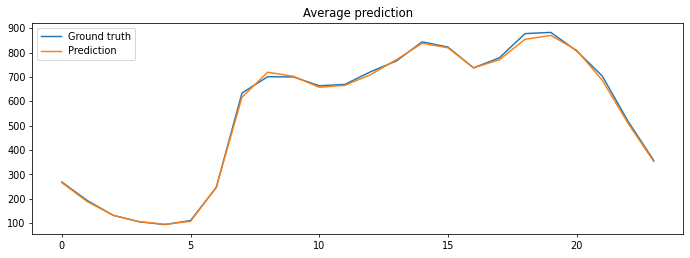

In [ ]:
real = y_tstep.mean(0)
prediction = y_pred_tstep.mean(0)

plt.figure('Results', figsize=(12, 4), dpi=70)

plt.plot(real, label = 'Ground truth')
plt.plot(prediction, label = 'Prediction')
plt.legend()
plt.title('Average prediction')

Learning Curve

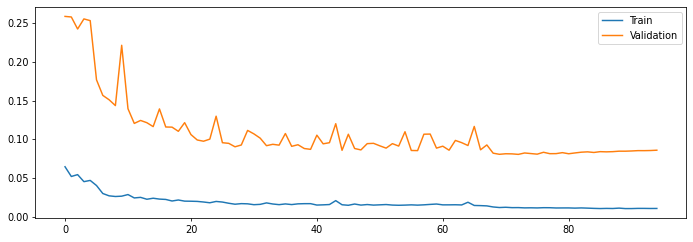

In [ ]:
plt.figure('Error', figsize=(12, 4), dpi=70)
plt.plot(np.sqrt(logs['train.mse']), label = 'Train')
plt.plot(np.sqrt(logs['val.mse']), label = 'Validation')
plt.legend()

Temporal RMSE distribution: hour

Text(0.5, 0, 'Hour of the day')

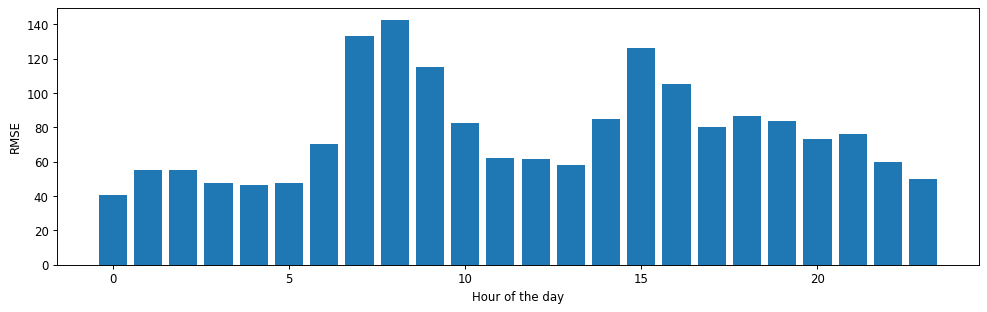

In [ ]:
plt.figure('RMSE dist hour', figsize=(14, 4), dpi=85)
plt.bar(x = range(0,24),height = rmse(y_pred_tstep,y_tstep, reduce = False))
plt.ylabel('RMSE')
plt.xlabel('Hour of the day')

Temporal RMSE distribution:n timestep

Text(0.5, 0, 'Timestep')

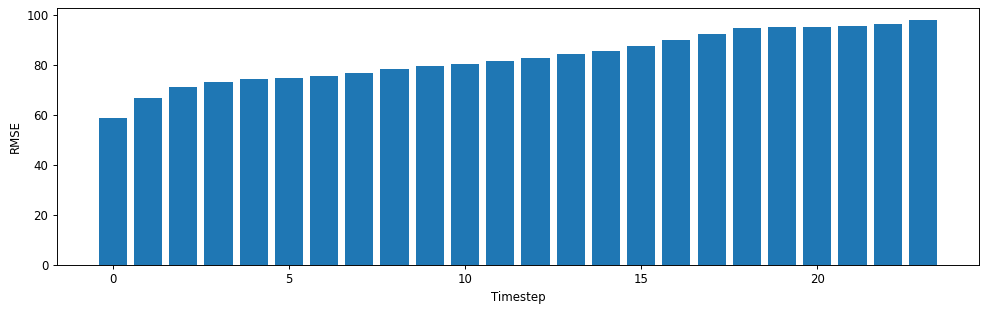

In [ ]:
plt.figure('RMSE dist timestep', figsize=(14, 4), dpi=85)
plt.bar(x = range(0,24),height = rmse(y_pred_dnorm, y_dnorm, reduce = False))
plt.ylabel('RMSE')
plt.xlabel('Timestep')

The main problem when switching between modules is the dimensionality of the dataset. You need to clear all variables before training the next module's submodel.

In [ ]:
%reset -f

# The Spatial Module

Once we move on to the next module, we need to re-index our directory in the shell, by rewinding one folder (cd -), then appending 'cd' with "Spatial Module". In this case, the directory has already been cleared by the '%reset -f' shell command.

In [ ]:
import os
os.chdir("/content/crann_traffic/Spatial module")

To bypass the dimensionality issue error, the workaround is to separate the ipython notebook to run each different submodel.

In [ ]:
import os
import json
import numpy as np

import torch

from dataset import data_transform
from utils import DotDict, Logger, bias, denormalize_data, rel_error, rmse
from sp_att_mech import AttentionCNN

import matplotlib.pyplot as plt
%matplotlib inline

Data importation & visualisation

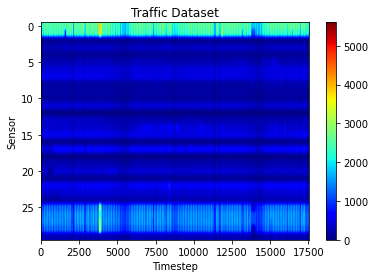

In [ ]:
datadir = 'data'
dataset = 'sp_data.csv'
data = torch.Tensor(np.genfromtxt(os.path.join('..',datadir, dataset)))

plt.figure('Traffic Dataset')
plt.imshow(data.squeeze().numpy().T, aspect='auto', cmap='jet')
plt.title('Traffic Dataset')
plt.xlabel('Timestep')
plt.ylabel('Sensor')
plt.colorbar()

Once we visualise the dataset, as the model is pre-designed, we can train the spatial submodel. But, that's on another worksheet: https://colab.research.google.com/drive/1BPraySSp7ymHibXc90oa3QuevrqMRop9?usp=sharing